In [5]:
import pickle
import numpy as np
import pandas as pd
import os, glob
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

## The following are the ML models which can be used for trasinning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import MinMaxScaler,StandardScaler

import timeit
import warnings
warnings.filterwarnings("ignore")


In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
%matplotlib inline
import pandas as pd

In [7]:
import seaborn as sns
sns.set(style="darkgrid")

In [8]:
sns.set_context('talk')

In [9]:
from IPython.display import display, HTML, Image

In [10]:
import matplotlib.colors as mcolors

In [11]:
dataFolder = os.getcwd()

In [12]:
group1_low =1.634
group2_low =0.673
group2_upper =1.634
group3_upper =0.673

In [13]:
## read the test file
data =pd.read_csv(os.path.join(dataFolder,'dataset5K_test.csv'))
data.columns =[col.strip() for col in data.columns]
data['ratio'] = data['b(CaO)']/data['b(SiO2)']
group1 = data[data['ratio']>=group1_low]  # with Portlandite, no Amor-S1
group2 = data[(data['ratio']<=group2_upper) & (data['ratio']>=group2_low)]  # no Portlandite, no Amor-S1
group3 = data[data['ratio']<=group3_upper]     # no Portlandite, with Amor-S1
groups = [group1,group2,group3]
dataCols = data.columns

In [14]:
## Read the scaler file

scaler = pickle.load(open('scalernew.pkl', 'rb'))
scalerSi = pickle.load(open('scalerSinew.pkl', 'rb'))


In [15]:
scaler.__dict__

{'with_mean': True,
 'with_std': True,
 'copy': True,
 'feature_names_in_': array(['b(CaO)', 'b(SiO2)', 'b(H2O)'], dtype=object),
 'n_features_in_': 3,
 'n_samples_seen_': 5005,
 'mean_': array([0.94967692, 0.44993281, 5.5505128 ]),
 'var_': array([0.24073308, 0.02083087, 2.56749708]),
 'scale_': array([0.49064558, 0.14432904, 1.60234113])}

In [16]:
scalerSi.__dict__

{'with_mean': True,
 'with_std': True,
 'copy': True,
 'feature_names_in_': array(['b(CaO)', 'b(SiO2)', 'b(H2O)', 'pH'], dtype=object),
 'n_features_in_': 4,
 'n_samples_seen_': 5005,
 'mean_': array([ 0.94967692,  0.44993281,  5.5505128 , 11.97808991]),
 'var_': array([0.24073308, 0.02083087, 2.56749708, 0.78589797]),
 'scale_': array([0.49064558, 0.14432904, 1.60234113, 0.88650886])}

In [17]:
modelSummary={'GPyModel':'ModelTrainSummary.csv'}

In [18]:
## read trained Model info:
def getReadyModelInfo(dataFolder,fileNameModelSummary,dataCols):
    
    modelInfo =pd.read_csv(os.path.join(dataFolder,fileNameModelSummary))
    
    modelInfo = modelInfo.iloc[:,1:4]
    ## load the mdoels
    dataCols = data.columns.to_list()
    modelsLst = []
    for irow,row in modelInfo.iterrows():
        group = row['group']
        var =row['var']
        modelType = row['modelType']
        icol =dataCols.index(var)
        if '/' in var:
            fileCol = var.replace("/",'')
        else:
            fileCol = var            
    
        modelFolder = os.path.join(dataFolder,'SavedModel',group)
        if modelType=='CONST':
            ext = '.csv'
            fileName = os.path.join(modelFolder,modelType +'_'+fileCol+ext)
            tempModel =pd.read_csv(fileName)
        else:
            ext ='.sav'
            fileName = os.path.join(modelFolder,modelType +'_'+fileCol+ext)
            tempModel = pickle.load(open(fileName, 'rb'))
        
        modelsLst.append(tempModel)
    
    modelInfo['modelObj'] = modelsLst 
    
    return modelInfo

In [19]:
inputColNames =['b(CaO)','b(SiO2)','b(H2O)']
inputColAqSiNames =['b(CaO)','b(SiO2)','b(H2O)','pH']    


In [20]:
finalDF = pd.DataFrame()
for ML,modelSummaryCsv in modelSummary.items():
    tempModelInfo = getReadyModelInfo(dataFolder,modelSummaryCsv,dataCols)
    for col in ['pH','nSi(aq)']: #group1.columns[4:-1]:  # exclude 'ratio' 
        colModelInfo = tempModelInfo[tempModelInfo['var'] == col]  
        
        for i, group in enumerate(groups):
        
            dataX = group.loc[:,inputColNames]    
            dataY = group[col].values
            groupModelInfo = colModelInfo[colModelInfo['group'] =='group'+str(i+1)]
            modelType = groupModelInfo['modelType'].values[0]
            model = groupModelInfo['modelObj'].values[0]
            if modelType=='CONST':
                y_pred = list(model['const'].values)*len(dataY)
                
            elif modelType=='linear':
                y_pred = model.predict(dataX.values)
            elif (col=='nSi(aq)' and i ==1):
                
                dfTemp = finalDF[(finalDF['group']=='group2') & (finalDF['var']=='pH')].reset_index(drop=True)
                testX = dataX.reset_index(drop=True)
                testX['pH'] = dfTemp['predDataY'].values
                testX_scaled = scalerSi.transform(testX.values) 
                y_pred  = model.predict(testX_scaled)
                
            else:
                #scaler = StandardScaler().fit(dataX.values)
                X_scaled = scaler.transform(dataX.values)  # This will be used for input of trainning dataset
                y_pred  = model.predict(X_scaled)  
    
            tempDF = pd.DataFrame({'testDataY':dataY, 'predDataY':y_pred})
            tempDF['modelType'] = [modelType]*len(tempDF)
            tempDF['var'] = [col]*len(tempDF)
            tempDF['group'] = ['group'+str(i+1)]*len(tempDF)
            tempDF['modelSimulation'] = [ML+'_simulation']*len(tempDF)
                
            if len(finalDF)==0:   
                finalDF = tempDF
            else:
                finalDF = pd.concat([finalDF,tempDF],axis=0)
    

In [21]:
finalDF[(finalDF['var']=='pH') & (finalDF['group']=='group2') ]

,testDataY,predDataY,modelType,var,group,modelSimulation
0,12.47261,12.467021,GPyModel,pH,group2,GPyModel_simulation
1,12.47259,12.472584,GPyModel,pH,group2,GPyModel_simulation
2,12.02964,12.030489,GPyModel,pH,group2,GPyModel_simulation
3,12.02193,12.022394,GPyModel,pH,group2,GPyModel_simulation
4,11.89120,11.891276,GPyModel,pH,group2,GPyModel_simulation
...,...,...,...,...,...,...
256,12.23858,12.239265,GPyModel,pH,group2,GPyModel_simulation
257,11.70151,11.701578,GPyModel,pH,group2,GPyModel_simulation
258,12.13015,12.131506,GPyModel,pH,group2,GPyModel_simulation
259,12.03867,12.038154,GPyModel,pH,group2,GPyModel_simulation


In [22]:
finalDF.to_csv('Comparison_predict_5KDataset.csv',index=False)

# Visualization of the prediction of the test dataset

In [23]:
def drawPlots(trgVar,testDataY,predDataY,simulation):
    
    fig, ax =plt.subplots(figsize=(8,8))
    
    RMSE = mean_squared_error(testDataY,predDataY)
    R2   = r2_score(testDataY,predDataY)
    axMax = max(max(testDataY),max(predDataY))
    axMin = min(min(testDataY),min(predDataY))
    #axMax =12.5
    #axMin =8.4
    ## Fitting the line           
    x2= np.linspace(axMin,axMax,30);
    y2 = x2
    ax.plot(testDataY,predDataY,'bo',markerfacecolor = 'blue',markeredgecolor ='darkblue',markeredgewidth=0.5,label=trgVar)
    
    #ax.plot(df3['b(SiO2)'].values,df3['b(CaO)'].values,'bo',markerfacecolor = 'c',markeredgecolor ='b',markeredgewidth=0.5,label='no Amor-S1')
    #ax.plot(group3['b(SiO2)'].values,group3['b(CaO)'].values,'g^',markerfacecolor = 'm',markeredgecolor ='m',markeredgewidth=1,label='group3')
    ax.plot(x2,y2,'r-',lw=3,label ='1:1 ratio')
    ax.legend (loc='best',ncol=5)           
    ax.set_xlim(axMin,axMax)
    ax.set_ylim(axMin,axMax)
    #ax.text(0.05, 0.8, 'Above the line with Portlandite',fontsize = 20,color = 'k')
    #ax.text(0.4, 0.50, 'Below the line no Portlandite',fontsize = 20,color = 'k')
    ax.set_title(simulation+ ' ====> '+trgVar)
    ax.set_xlabel('testDataY')
    ax.set_ylabel('PredDataY')    
        
    return R2, RMSE    

In [24]:
finalDF['var'].unique()

array(['pH', 'nSi(aq)'], dtype=object)

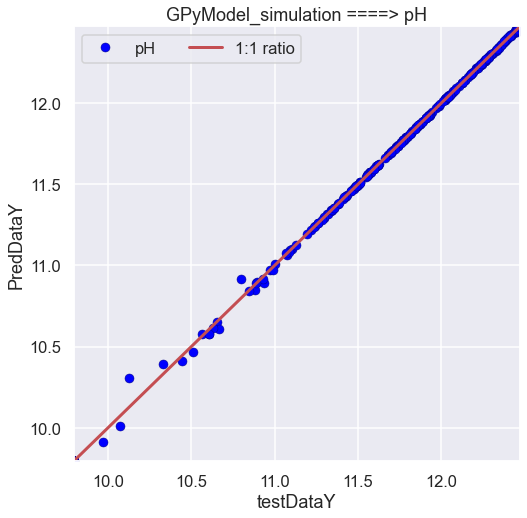

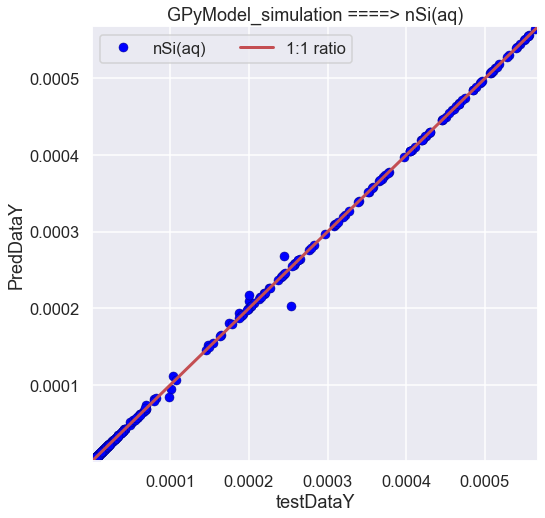

In [25]:
modelSimulations = finalDF['modelSimulation'].unique()
trgVars = finalDF['var'].unique()
statMeasure = []
for simulation in modelSimulations:
    tempDF = finalDF[finalDF['modelSimulation']==simulation]
    for trgVar in trgVars:
        df = tempDF[tempDF['var']==trgVar]  # no Portlandite
        testDataY = df['testDataY'].values
        predDataY = df['predDataY'].values
        R2,RMSE = drawPlots(trgVar,testDataY,predDataY,simulation)
        statMeasure.append([trgVar,R2,RMSE,simulation])
    
statMeasDF = pd.DataFrame(statMeasure,columns=['Var','R2','RMSE','modelSimulation'])    
